In [1]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt
from os.path import exists
from HierarchicalModel import HierarchicalModel

Using TensorFlow backend.


### Select the training configuration

In [3]:
# ================== HYPER-PARAMETERS ==================
# config: nr_classes, labels, class_weights, basemodel, image_dimension, results_and_checkpoints_folder, data_folder
i = 106
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]
old_stdout = sys.stdout
config['batch_size'] = 32
if not exists(config['results_folder'] + '/log_eval.txt'):
    log_file = open(config['results_folder'] + '/log_eval.txt', 'w')
else:
    raise FileExistsError
sys.stdout = log_file

In [4]:
THRESHOLD_MOVE = False

Load test set

In [ ]:
# Load test set
test, _ = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                      batch_size=config['batch_size'],
                      nr_classes=config['nr_classes'],
                      image_dimension=config['image_dimension'])

# Create model
if config['hierarchical']:
    model = HierarchicalModel(nr_labels=len(test.class_indices), image_dimension=config['image_dimension'])
else:
    if config['nr_classes'] == 'all':
        n_labels = len(test.class_indices)
    model = hf.create_model(n_labels=n_labels, image_dimension=config['image_dimension'], model_name=config['basemodel'], number_trainable_layers=config['number_trainable_layers'])
# latest = tf.train.latest_checkpoint(config['results_folder'] + '/checkpoints')
latest = tf.train.latest_checkpoint(config['results_folder'])
print(latest)
model.load_weights(latest)

# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=2)
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
y_pred_test_05 = 1 * (probs_test > 0.5)

if THRESHOLD_MOVE:
    val_threshold, _ = hf.get_flow(df_file=config['data_folder'] + '/val_threshold_df.json.bz2',
                                   batch_size=config['batch_size'],
                                   nr_classes=config['nr_classes'],
                                   image_dimension=config['image_dimension'])
    # Use the second validation set to the thresholds that optimize f1-score
    print('Predicting on validation set:\n')
    probs_val = model.predict(val_threshold, verbose=2)
    y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)

    optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                            probs=probs_val, 
                                            thresholds=np.linspace(start=0, stop=1, num=21), 
                                            labels=list(val_threshold.class_indices.keys()), 
                                            N=7,
                                            image_path=config['results_folder'])
    y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)

In [ ]:
def plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, image_path):
    plt.figure(figsize=(12, 6))
    x_axis = np.arange(len(f1_scores_05.keys()))
    plt.bar(x_axis-0.1, f1_scores_05.values, width=0.2, label='Threshold 0.5')
    plt.bar(x_axis+0.1, f1_scores_thresh.values, width=0.2, label='Per-class threshold')
    plt.legend(fontsize=12)
    _ = plt.xticks(x_axis, f1_scores_05.keys(), rotation=70, rotation_mode='anchor', ha="right", fontsize=14)
    # plt.title('F1-scores comparison')
    plt.ylabel('F1-score')
    plt.xlabel('Label')
    try:
        plt.savefig(image_path + '/f1-scores-threshold-moving-or-05.png', bbox_inches='tight')
    except:
        print('Could not save image')

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


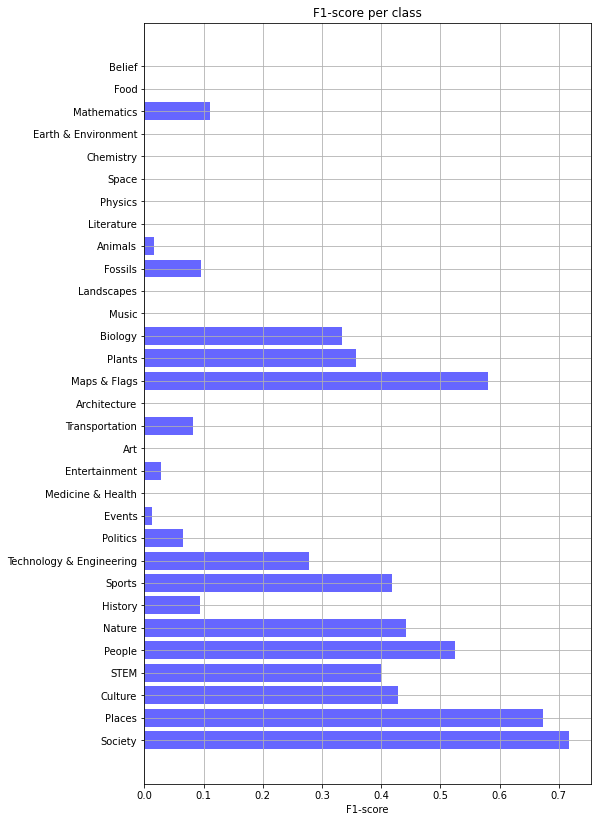

In [ ]:
# ================== GET METRICS ======================
print('METRICS FOR THRESHOLD 0.5')
f1_scores_05 = hf.get_metrics(y_true_test, y_pred_test_05, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')

if THRESHOLD_MOVE:
    print('METRICS WHEN HAVING PER-CLASS THRESHOLDS')
    f1_scores_thresh = hf.get_metrics(y_true_test, y_pred_test_per_class_threshold, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')
    plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, config['results_folder'])

In [ ]:
# # ============== CONFUSION MATRICES ===================
# from sklearn.metrics import multilabel_confusion_matrix

# confusion_matrix = multilabel_confusion_matrix(y_true_test, y_pred_test)
# hf.plot_confusion_matrices(confusion_matrix, list(test.class_indices.keys()), config['results_folder'])                                                     
# ======================================================

### Precision recall curve

<Figure size 1080x720 with 0 Axes>

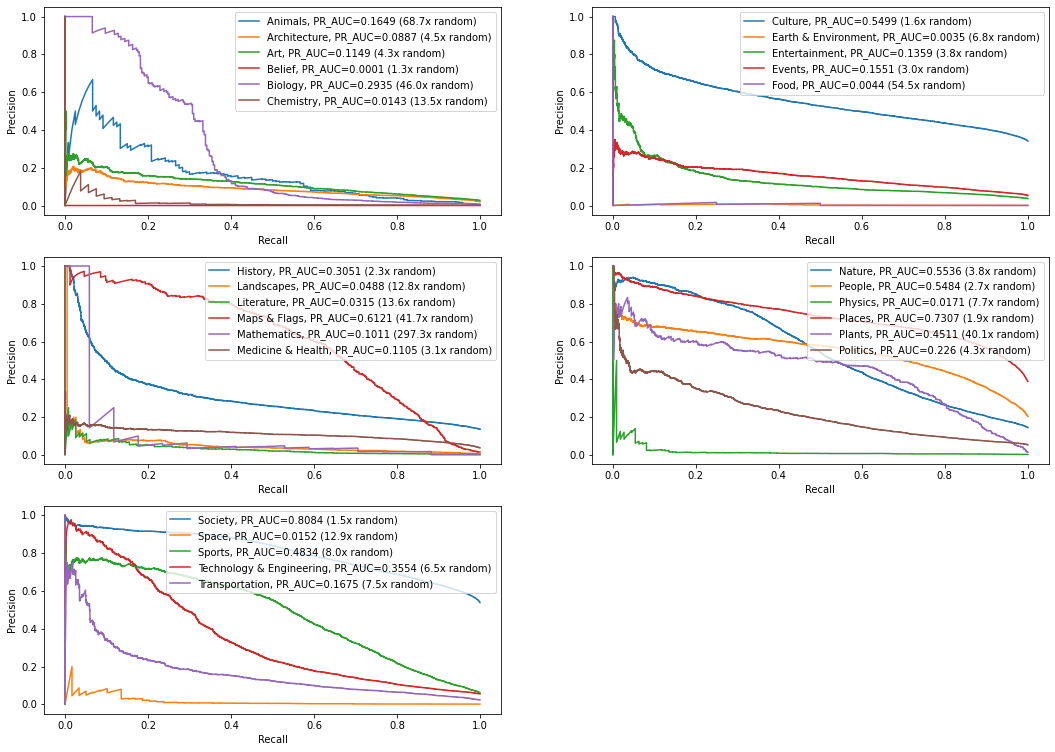

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# precision recall curve
def plot_pr_curve(y_true, probs, label_names):
    plt.figure(figsize=(15,10))
    precision = dict()
    recall = dict()
    pr_auc = dict()
    random_auc = dict()
    n_images = y_true.shape[0]
    n_labels = len(label_names)

    for i in range(n_labels):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        random_auc[i] = y_true[:, i].sum() / n_images

    plt.figure(figsize=(18, 13))
    
    plt.subplot(3, 2, 1)
    for i in range(0, 6):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 2)
    for i in range(6, 11):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 3)
    for i in range(12, 18):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 4)
    for i in range(19, 25):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 5)
    for i in range(26, 31):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')
    plt.show()
    hf.save_img(config['results_folder'] + '/pr_curve.png')
    
    return precision, recall, pr_auc, random_auc

precision, recall, pr_auc, random_auc = plot_pr_curve(y_true_test, probs_test, list(test.class_indices.keys()))


In [9]:
metrics_dict = dict()
metrics_dict['label_name'] = list(test.class_indices.keys())
metrics_dict['pr_auc'] = list(pr_auc.values())
metrics_dict['random_auc'] = list(random_auc.values())
metrics_df = pd.DataFrame(metrics_dict)
metrics_df['better_than_random'] = round(metrics_df['pr_auc'] / metrics_df['random_auc'], 3)
macro_pr_auc = metrics_df['pr_auc'].sum() / len(metrics_df)
print(f'\n\n-------------------------- PR AUC metrics table -----------------------')
print(f'Macro PR_AUC is: {macro_pr_auc}')
print(metrics_df)
metrics_df.head(31)

,label_name,pr_auc,random_auc,better_than_random
0,Animals,0.164896,0.00240,68.707
1,Architecture,0.088670,0.01982,4.474
2,Art,0.114872,0.02676,4.293
3,Belief,0.000050,0.00004,1.251
4,Biology,0.293471,0.00638,45.999
5,Chemistry,0.014296,0.00106,13.487
6,Culture,0.549928,0.34052,1.615
7,Earth & Environment,0.003514,0.00052,6.758
8,Entertainment,0.135883,0.03584,3.791
9,Events,0.155109,0.05202,2.982


In [9]:
print('\n\n----------------------Sorted by the best PR_AUC-------------------')
print(metrics_df.sort_values('pr_auc', ascending=False))
metrics_df.sort_values('pr_auc', ascending=False)


,label_name,pr_auc,random_auc,better_than_random
26,Society,0.749796,0.53782,1.394
22,Places,0.687566,0.38878,1.769
20,People,0.492898,0.20262,2.433
15,Maps & Flags,0.490895,0.01468,33.440
6,Culture,0.463371,0.34052,1.361
25,STEM,0.445204,0.23260,1.914
19,Nature,0.438558,0.14398,3.046
28,Sports,0.393023,0.06060,6.486
23,Plants,0.357514,0.01124,31.807
4,Biology,0.257021,0.00638,40.285


In [10]:
print('\n\n----------------------Sorted by the best compared to random-------------------')
print(metrics_df.sort_values('better_than_random', ascending=False))
metrics_df.sort_values('better_than_random', ascending=False)

,label_name,pr_auc,random_auc,better_than_random
16,Mathematics,0.147082,0.00034,432.593
0,Animals,0.181395,0.00240,75.581
4,Biology,0.257021,0.00638,40.285
15,Maps & Flags,0.490895,0.01468,33.440
23,Plants,0.357514,0.01124,31.807
11,Fossils,0.074308,0.00278,26.729
10,Food,0.001018,0.00008,12.727
13,Landscapes,0.046755,0.00380,12.304
28,Sports,0.393023,0.06060,6.486
5,Chemistry,0.005943,0.00106,5.607


#### ROC curve for each class

On micro and macro averaging: Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

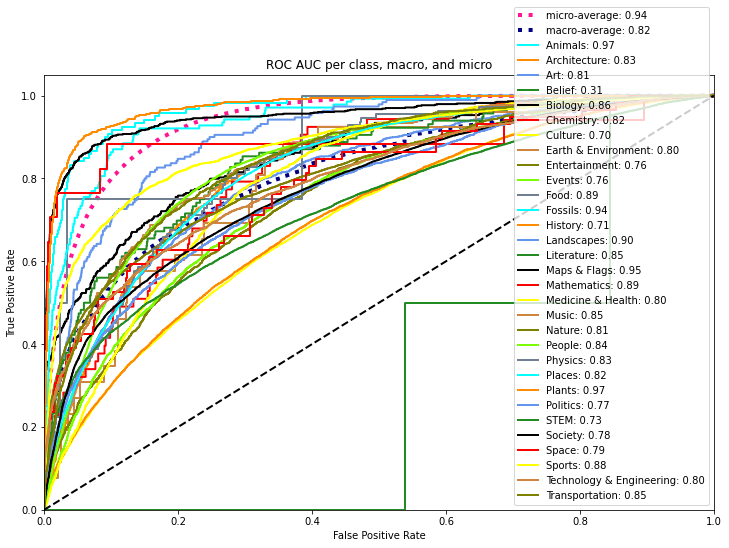

In [35]:
# ================== ROC CURVE PER CLASS ===============
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc(y_true, predictions, label_names):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_labels = y_true.shape[1]

    for i in range(n_labels):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw = 2
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_labels)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_labels):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_labels

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves

    plt.figure(figsize=(12, 8))

    plt.plot(fpr["micro"],
             tpr["micro"],
             label=f"micro-average: { roc_auc['micro'] :0.2f}",
             color="deeppink",
             linestyle=":",
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label=f"macro-average: { roc_auc['macro'] :0.2f}",
             color="navy",
             linestyle=":",
             linewidth=4)

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "black", "red", "yellow", "peru", "olive", "lawngreen", "slategray"])
    for i, color in zip(range(n_labels), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label=f"{label_names[i]}: {roc_auc[i]:0.2f}")

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC per class, macro, and micro')
    plt.legend(loc='lower right')
    hf.save_img(config['results_folder'] + '/roc_curves.png')

plot_roc(y_true_test, probs_test, list(test.class_indices.keys()))

In [8]:
sys.stdout = old_stdout

log_file.close()